# Prova de N = 128

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
import matplotlib.ticker as ticker
logger = logging.getLogger(__name__)
from IPython.display import display
import scienceplots
plt.style.use('science')



""" Funcions per calcular els autovalors exactes """
# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2))
    disprel_odd = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2))
    disprel = disprel_even * disprel_odd
    return disprel

def dispersion_relation2(omega):
    disprel_even2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2))
    disprel_odd2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2))
    disprel2 = disprel_even2 * disprel_odd2
    return disprel2

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        sol2 = fsolve(dispersion_relation2, omega0)

        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        if sol2 > 0:
            exact_soln = np.append(exact_soln, sol2)
            exact_soln = np.unique(exact_soln.round(decimals=8))

        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
#    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln



""" Paràmetres """
Nx = 128 # Nombre de punts de la malla (128, 256, 512, 1024, 2048)
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]



""" Constants """
kz = 0.01
#B0 = 0

### Velocitats a trossos ###
cp2 = 1
cc2 = 6 # 6
vAp2 = 20 # 9
vAc2 = 250 # 36
# Valors realistes: cp2, cc2, vAp2, vAc2  137724550.89820358 27544910179.640717 3978873577.297384 795774715459.4768



""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ###
u = dist.Field(name='u', bases=xbasis) # u = field of the wave function - AUTOFUNCIÓ!!! - v10x bar, coplexa
w = dist.Field(name='w', bases=xbasis) # w = Velocity in the x direction   v10z - real
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Espai real ###
x = dist.local_grid(xbasis)

### Constants ###
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.

### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Camps magnètics ###
#Bx = dist.Field(name='Bx', bases=xbasis) # Bx = Magnetic field in the x direction   B10x
#Bz = dist.Field(name='Bz', bases=xbasis) # Bz = Magnetic field in the z direction   B10z

### Densitats ###
#rho0 = dist.Field(name='rho0', bases=xbasis) # rho0 = Density of the plasma  ρ0
#rho10 = dist.Field(name='rho10', bases=xbasis) # rho = Variation density of the plasma   ρ10
#rho10['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [1, 1, 1]) # Representa la densitat en l'espai real ('g') a trossos.

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
tau_3 = dist.Field(name='tau_3')
tau_4 = dist.Field(name='tau_4')



""" Derivades """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction of the velocity in the x direction
uxx = dx(ux) + lift(tau_2) # Second-order reduction of the velocity in the x direction
wx = dx(w) + lift(tau_3) # First-order reduction of the velocity in the z direction
wxx = dx(wx) + lift(tau_4) # Second-order reduction of the velocity in the z direction
# No és convenient posar directament dx(u) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!

# RESOLDRE PRIMER SUBSTITUINT Bx, Bx i RHO i només resolent 2 eqs... i 4 eqs de contorn, només resolem per u i w, eqs. (17') i (19')



""" Problema """
### Problema d'ones ràpida i lenta (complet) ###
#problem = d3.EVP([u, w, Bx, Bz, rho0, rho10, tau_1, tau_2,], eigenvalue=s, namespace=locals())
#problem.add_equation("np.sqrt(s)*rho10 + rho0*(-wx - kz*w) =0 ") # (12)
#problem.add_equation("np.sqrt(s)*Bx = kz*B0*w") # (14)
#problem.add_equation("np.sqrt(s)*Bz = B0*ux") # (16)
#problem.add_equation("np.sqrt(s)*rho10*ux = -c2*rho10x ") # (17)
#problem.add_equation("np.sqrt(s)*rho10*w - c2*kz*rho10 - vA2*(rho/B0)*(kz*Bx -Bzx) = 0") # (19)

### Problema d'ones d'Alfvén ### ~ corda guitarra amb densitat variable
#problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
#problem.add_equation("s * u  +  vA2 * uxx  =  0") # (12)

### Problema d'ones ràpida i lenta (més treballat) ###
problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals()) # 2 equacions i 4 incògnites
# problem.add_equation("s * u  +  c2 * uxx  =  0") # (17') # amb kz = 0
# problem.add_equation("s * w  +  vA2 * wxx  =  0") # (19') # amb kz = 0. Hauríem d'obtenir una molt semblant a la (17') però amb la velocitat en z i la constant d'Alfvén
problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
problem.add_equation("u(x=xmin) = 0")
problem.add_equation("u(x=xmax) = 0")
problem.add_equation("w(x=xmin) = 0")
problem.add_equation("w(x=xmax) = 0")
print("Number of unknowns:", len(problem.variables))
print("Number of equations:", len(problem.equations))



""" Solver """
### Solver de Dedalus ###
solver = problem.build_solver()
#print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

### Ajustament de les autofuncions ###
print('evals.size (before) ', evals.size)
#evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

### Autovalors exactes ###
Nevals = evals.size
exact_soln = get_eigenvalues(Nevals)
n = 1 + np.arange(evals.size)
true_evals = exact_soln[0:evals.size]

### Error relatiu ###
relative_error = np.abs(evals - true_evals) / true_evals

### Autovalors ###
print('evals size', evals.size)
print("true_evals size ", true_evals.size)
#print("Evals", evals)
#print("True Evals", true_evals)

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("First 5 True eigenvalues:", true_evals[:5])
print("Relative error:", relative_error[:5])
print()  # This adds a blank line


Number of unknowns: 6
Number of equations: 6
2025-05-14 20:09:47,652 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 13s, Remaining: 0s, Rate: 7.6e-02/s
evals.size (before)  260
evals.size (after removing inf)  260
evals.size (after removing < 0)  260

evals size 260
true_evals size  260
First 5 Eigenvalues (sqrt): [ 2.62441289  7.53738215  9.29494752 11.71636659 13.71111546]
First 5 True eigenvalues: [ 2.66901857  7.55178196  9.34725317 13.17871403 13.9452195 ]
Relative error: [0.01671239 0.00190681 0.00559583 0.11096283 0.0167874 ]



# Representació de l'error

[]

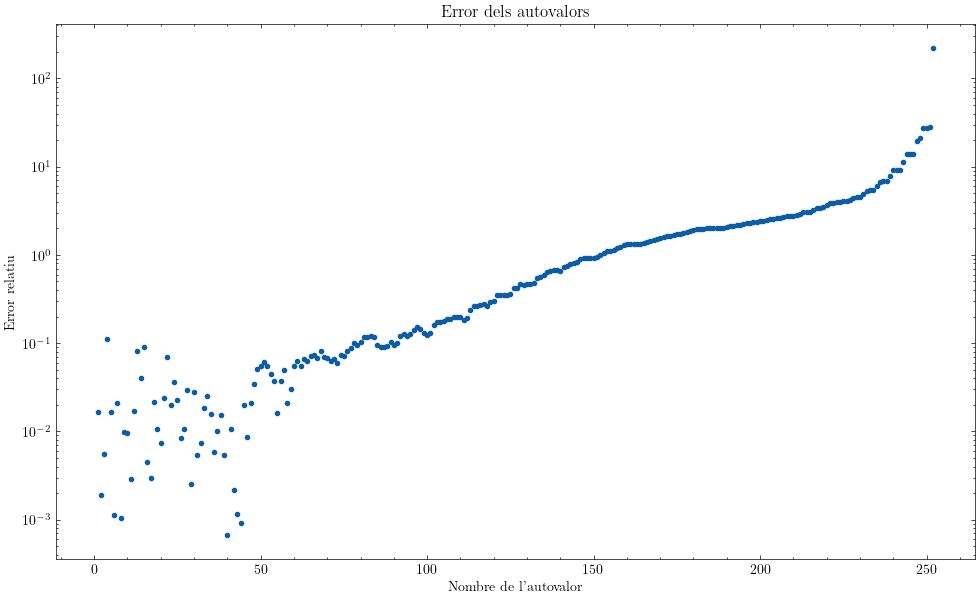

In [3]:
plt.figure(figsize=(10, 6))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Nombre de l'autovalor")
plt.ylabel("Error relatiu")
plt.tight_layout()
plt.title("Error dels autovalors")
plt.grid(False)
plt.plot()
#plt.savefig('eigenvalue_error.png', dpi=300)

# Representació de les autofuncions

/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_85643/3249276469.py:28: RuntimeWarning: invalid value encountered in divide
  ui = u['g'].imag/(u['g'][1]).imag
/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_85643/3249276469.py:29: RuntimeWarning: invalid value encountered in divide
  wi = w['g'].imag/(w['g'][1]).imag


Maximum value is ug = 906.114262437979 and minimum value is wg = 258.72584945138425
Maximum value is wg = 1624.0142228266786 and minimum value is ug = 354.6708620146936
Maximum value is wg = 466.1563110333601 and minimum value is ug = 264.1974792087681
Maximum value is ug = 3554.3434837063223 and minimum value is wg = 1033.7663712889191


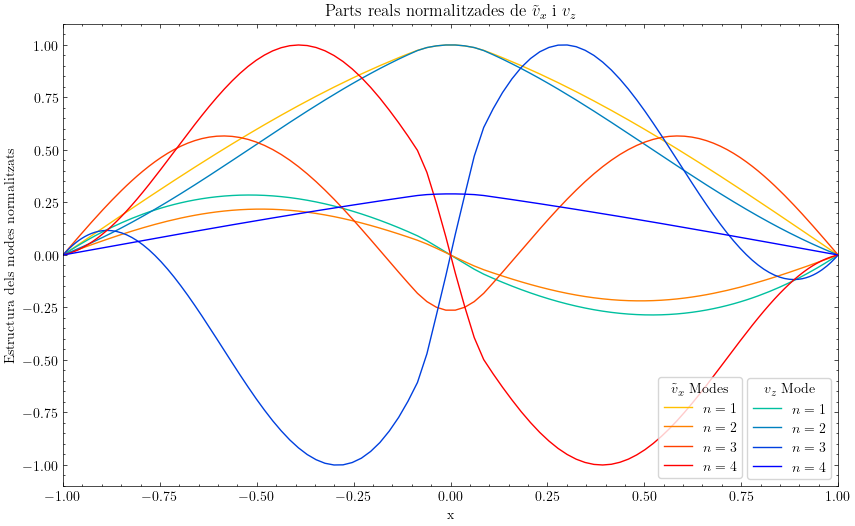

In [6]:
### Nombre de modes que volem representar ###
N_max_mode = 4
N_min_mode = 0
N_modes = N_max_mode - N_min_mode

### Define warm and cold color palettes ###
cmap_warm = plt.get_cmap('autumn')  # Warm color palette for v10x~
cmap_cold = plt.get_cmap('winter')   # Cold color palette for v10z
colors_warm = [cmap_warm(i / N_modes) for i in range(N_modes)]    # Warm colors
colors_cold = [cmap_cold(i / N_modes) for i in range(N_modes)]    # Cold colors

### Create lists to store handles for legends ###
handles_v10x = []
handles_v10z = []

### Plot ug.real and wg.real and normalize to the maximum value ###

x = dist.local_grid(xbasis)
ug_max_list = []
ug_min_list = []
wg_max_list = []
wg_min_list = []
plt.figure(figsize=(10, 6))
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag/(u['g'][1]).imag
    wi = w['g'].imag/(w['g'][1]).imag
    
    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Print the maximum value
    if np.max(np.abs(ug)) > np.max(np.abs(wg)):
        print("Maximum value is ug =", max_val,"and minimum value is wg =", np.max(np.abs(wg)))
    else:
        print("Maximum value is wg =", max_val,"and minimum value is ug =", np.max(np.abs(ug)))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    # Append the values to the lists to display in the DataFrame
    ug_max_list.append(np.max(ug_normalized))
    ug_min_list.append(np.min(ug_normalized))
    wg_max_list.append(np.max(wg_normalized))
    wg_min_list.append(np.min(wg_normalized))

    # Plot v10x~ with warm colors and store the handle
    handle_v10x, = plt.plot(x, ug_normalized, label=fr"$n={n}$", color=colors_warm[ - n])
    handles_v10x.append(handle_v10x)

    # Plot v10z with cold colors and store the handle
    handle_v10z, = plt.plot(x, wg_normalized, label=fr"$n={n}$", color=colors_cold[ - n])
    handles_v10z.append(handle_v10z)

    # Create a DataFrame to display the results
    data = {
        "Mode": [f"Mode {i+1}" for i in range(len(ug_max_list))],
        "ug_max": ug_max_list,
        "wg_max": wg_max_list,
        "ug_min": ug_min_list,
        "wg_min": wg_min_list,}
    df = pd.DataFrame(data)

## Create separate legends
legend_v10x = plt.legend(handles=handles_v10x, title=r"$\tilde{v}_{x}$ Modes", loc="upper right", bbox_to_anchor=(0.885, 0.25), frameon=True)
plt.gca().add_artist(legend_v10x)  # Add the first legend to the plot
plt.legend(handles=handles_v10z, title=r"$v_{z}$ Mode", loc="lower right", bbox_to_anchor=(1, 0), frameon=True)


plt.xlim(-1, 1)
#plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Estructura dels modes normalitzats")
plt.xlabel(r"x")
plt.title(r"Parts reals normalitzades de $\tilde{v}_{x}$ i ${v}_{z}$")
plt.grid(False)
plt.savefig('normalized_modes.png', dpi=300, bbox_inches='tight')
plt.show()



# Tal vegada em pot interessar normalitzar en un bucle i després representar per separat. No representar tot de cop... però sí pq les vull comparar en tamany...

# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat u és en la direcció x i la w en z. També que v10x és imaginària i v10z és real.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la: aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima, no és que la corda es deformi amb aquella forma.

# Ficar els plots de les velocitats dins el for i representar les velocitats per cada kz... pot tardar bastant però crec que és el que he de fer!

# No entenc molt bé perquè els modes no es van alternant, és a dir, els modes senars el màxim hauria de ser ug i els parells wg; NO ESTÀ PASSANT AIXÒ PERÒ!

# Autofuncions individuals

Maximum value is from ug; max_val = 906.114262437979
Maximum value is from wg; max_val = 1624.0142228266786
Maximum value is from wg; max_val = 466.1563110333601
Maximum value is from ug; max_val = 3554.3434837063223


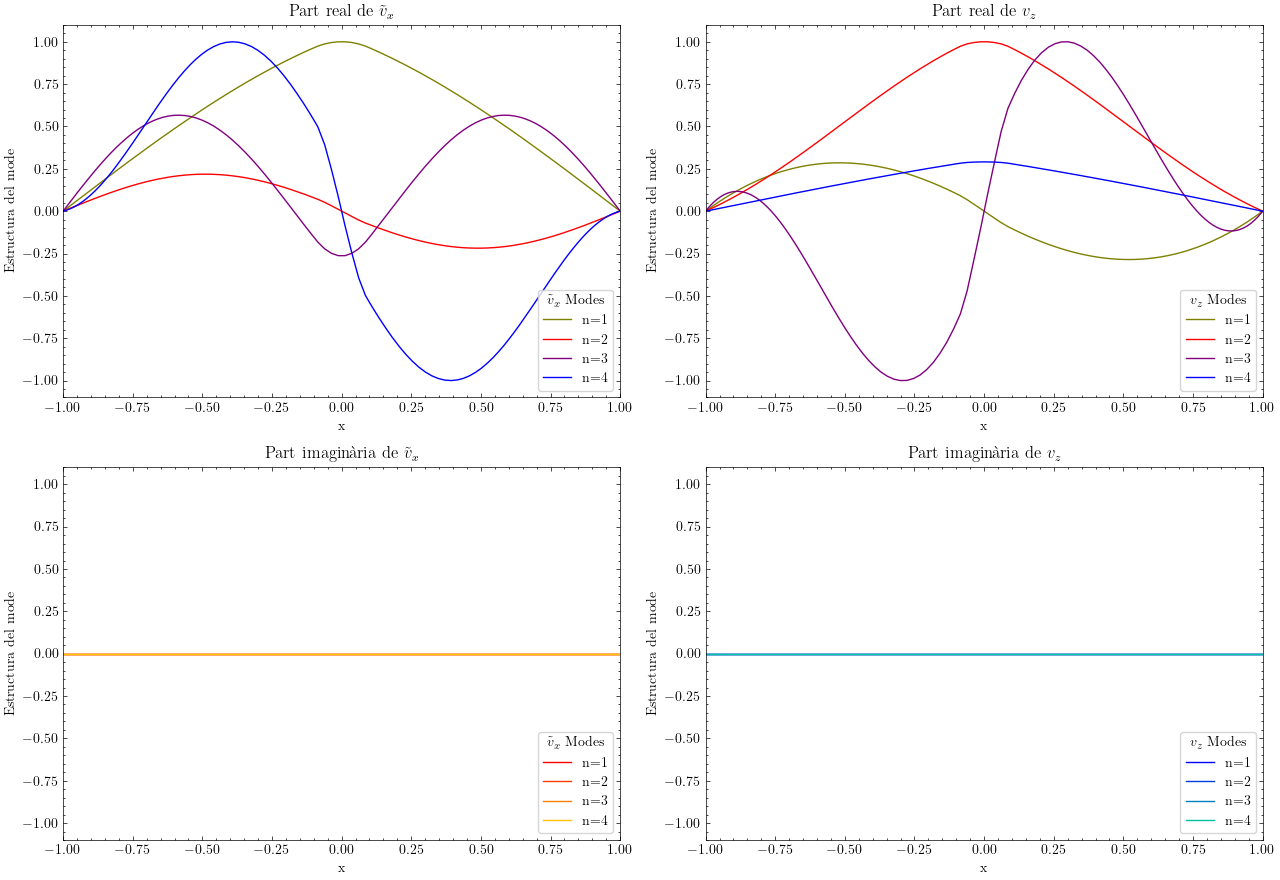

In [ ]:
### Create a figure and a 2x2 grid of subplots ###
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

### Define color palettes ###
cmap_viridis = plt.get_cmap('viridis')
colors_viridis = [cmap_viridis(i / N_modes) for i in range(N_modes)]
cmap_brg = plt.get_cmap('brg')
colors_brg = [cmap_brg(i / N_modes) for i in range(N_modes)]

### Initialize lists to store handles for legends ###
handles_v10x_real = []
handles_v10x_imag = []
handles_v10z_real = []
handles_v10z_imag = []

### Plot real part of v10x~ ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Print the maximum value
    if np.max(np.abs(ug)) > np.max(np.abs(wg)):
        print("Maximum value is from ug; max_val =", max_val)
    else:
        print("Maximum value is from wg; max_val =", max_val)

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    axs[0, 0].plot(x, ug/np.max(np.abs(max_val)), label=f"n={n}", color=colors_brg[-n])
axs[0, 0].set_ylim(-1.1, 1.1)
axs[0, 0].set_xlim(-1, 1)
axs[0, 0].legend(loc="lower right", frameon=True, title=r"$\tilde{v}_{x}$ Modes")
axs[0, 0].set_ylabel(r"Estructura del mode")
axs[0, 0].set_xlabel(r"x")
axs[0, 0].set_title(r"Part real de $\tilde{v}_{x}$") # idò és imaginària ---> desfassament temporal de 1/4 de període

### Plot imaginary part of v10x~ ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag
    wi = w['g'].imag

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    axs[1, 0].plot(x, ui/np.max(np.abs(max_val)), label=f"n={n}", color=colors_warm[n - 1])
axs[1, 0].set_ylim(-1.1, 1.1)
axs[1, 0].set_xlim(-1, 1)
axs[1, 0].legend(loc="lower right", frameon=True, title=r"$\tilde{v}_{x}$ Modes")
axs[1, 0].set_ylabel(r"Estructura del mode")
axs[1, 0].set_xlabel(r"x")
axs[1, 0].set_title(r"Part imaginària de $\tilde{v}_{x}$") # idò és real ---> desfassament temporal de 1/4 de període



### Plot real part of v10z ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    axs[0, 1].plot(x, wg/np.max(np.abs(max_val)), label=f"n={n}", color=colors_brg[-n])
axs[0, 1].set_ylim(-1.1, 1.1)
axs[0, 1].set_xlim(-1, 1)
axs[0, 1].legend(loc="lower right", frameon=True, title=r"${v}_{z}$ Modes")
axs[0, 1].set_ylabel(r"Estructura del mode")
axs[0, 1].set_xlabel(r"x")
axs[0, 1].set_title(r"Part real de ${v}_{z}$")

### Plot imaginary part of v10z ###
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag
    wi = w['g'].imag

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val
    
    axs[1, 1].plot(x, wi/np.max(np.abs(max_val)), label=f"n={n}", color=colors_cold[n - 1])
axs[1, 1].set_ylim(-1.1, 1.1)
axs[1, 1].set_xlim(-1, 1)
axs[1, 1].legend(loc="lower right", frameon=True, title=r"${v}_{z}$ Modes")
axs[1, 1].set_ylabel(r"Estructura del mode")
axs[1, 1].set_xlabel(r"x")
axs[1, 1].set_title(r"Part imaginària de ${v}_{z}$")

plt.tight_layout()
plt.show()

#fig.savefig("Autofuncions_individuals.png", dpi=300, bbox_inches='tight')

# Representació d'un mode en funció de kz

2025-05-14 20:13:11,186 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_85643/2691222713.py:86: RuntimeWarning: invalid value encountered in divide
  wg = w['g'].real/(w['g'][1]).real
/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_85643/2691222713.py:88: RuntimeWarning: invalid value encountered in divide
  wi = w['g'].imag/(w['g'][1]).imag


2025-05-14 20:13:11,980 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2025-05-14 20:13:12,936 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2025-05-14 20:13:14,108 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_85643/2691222713.py:87: RuntimeWarning: invalid value encountered in divide
  ui = u['g'].imag/(u['g'][1]).imag


2025-05-14 20:13:15,282 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s
2025-05-14 20:13:16,650 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2025-05-14 20:13:17,485 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s
2025-05-14 20:13:18,457 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2025-05-14 20:13:19,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s
2025-05-14 20:13:20,880 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s
2025-05-14 20:13:22,473 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2025-05-14 20:13:23,579 subsystems 0/1 INFO :: Building subproblem matrices 

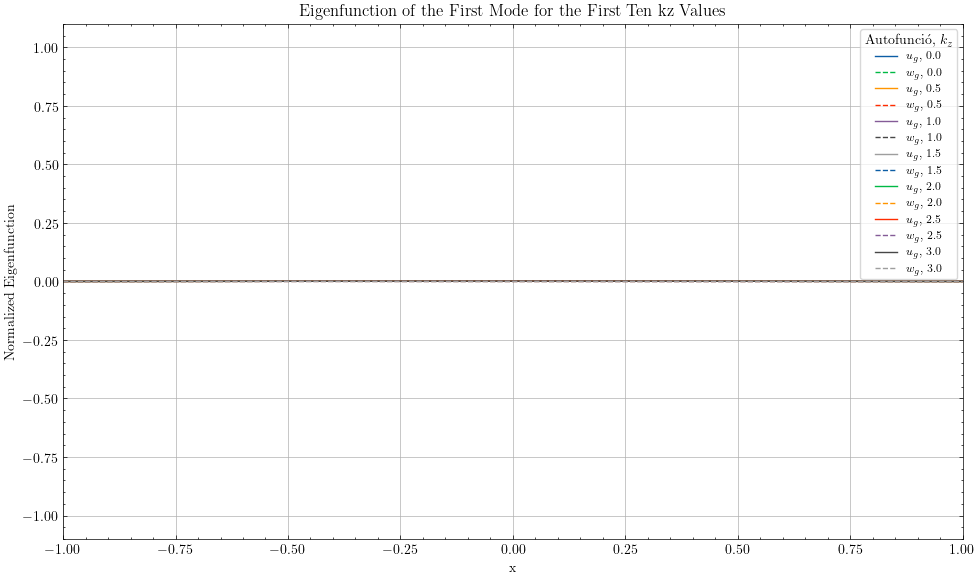

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
import matplotlib.ticker as ticker
logger = logging.getLogger(__name__)
from IPython.display import display
import scienceplots
plt.style.use('science')



""" Paràmetres """
Nx = 128 # amb 32 ja no és smooth...
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]



""" Constants """
### Velocitats a trossos ###
cp2 = 1 # 12 ### 1
cc2 = 6 # 166 ### 6
vAp2 = 20 # 60 to 100 ### 9
vAc2 = 250 # 1400 ### 36 - NO!
# CANVIAR VELOCITATS

# Valors realistes: cp2, cc2, vAp2, vAc2  137724550.89820358 27544910179.640717 3978873577.297384 795774715459.4768

### Redefinim camps ### -------- TALV VEGADA INFLUEIXEN EN ELS RESULTATS D'UN MODE SEGONS KZ...
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.

### Nombre de kz's ###
Nkz = 151 # Nombre de kz's
kz_list = np.linspace(0, 3, Nkz) # Hi ha Nkz's separats equidistantment entre 0 i 3



""" Relació de dispersió """
### Llistes per guardar les autofuncions ###
#ug_normalized_list = []
#wg_normalized_list = []

#evals_k = np.zeros((kz_list.size, evals.size), dtype=np.complex128)
# Inicialitza evals_k amb la mida correcta
evals_k = np.zeros((kz_list.size, len(solver.eigenvalues)), dtype=np.complex128)

plt.figure(figsize=(10, 6))

### Bucle per resolre el problema per cada kz ###
for ik, kz in enumerate(kz_list):
    problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals())
    problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
    problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
    problem.add_equation("u(x=xmin) = 0")
    problem.add_equation("u(x=xmax) = 0")
    problem.add_equation("w(x=xmin) = 0")
    problem.add_equation("w(x=xmax) = 0")

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0])

    evals_k[ik, :] = np.sort(solver.eigenvalues)

    # Extract the first eigenvalue and its corresponding eigenfunction
    first_mode_idx = np.argsort(solver.eigenvalues)[0]  # Index del mode
    solver.set_state(first_mode_idx, solver.subsystems[0])  # Set the solver state to the  desired mode

    # Extract the eigenfunctions
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag/(u['g'][1]).imag
    wi = w['g'].imag/(w['g'][1]).imag

    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    # Append the normalized eigenfunctions to the lists
    #ug_normalized_list.append(ug_normalized)
    #wg_normalized_list.append(wg_normalized)

    # Plot only for specific kz values
    if kz in [0, 0.5, 1, 1.5, 2, 2.5, 3]:
        # Plot ug
        plt.plot(x, ug_normalized/np.max(np.abs(max_val)), label=f"$u_g$, {kz:.1f}", linestyle='-')
    
        # Plot wg
        plt.plot(x, wg_normalized/np.max(np.abs(max_val)), label=f"$w_g$, {kz:.1f}", linestyle='--')


# Add labels, legend, and title
plt.xlabel("x")
plt.ylabel("Normalized Eigenfunction")
plt.xlim(-1, 1)
plt.ylim(-1.1, 1.1)
plt.title("Eigenfunction of the First Mode for the First Ten kz Values")
plt.legend(title=fr"Autofunció, $k_z$", loc="upper right", frameon=True, fontsize=8, framealpha=0.75)
plt.grid(True)
plt.tight_layout()
plt.show()

# Relació de dispersió

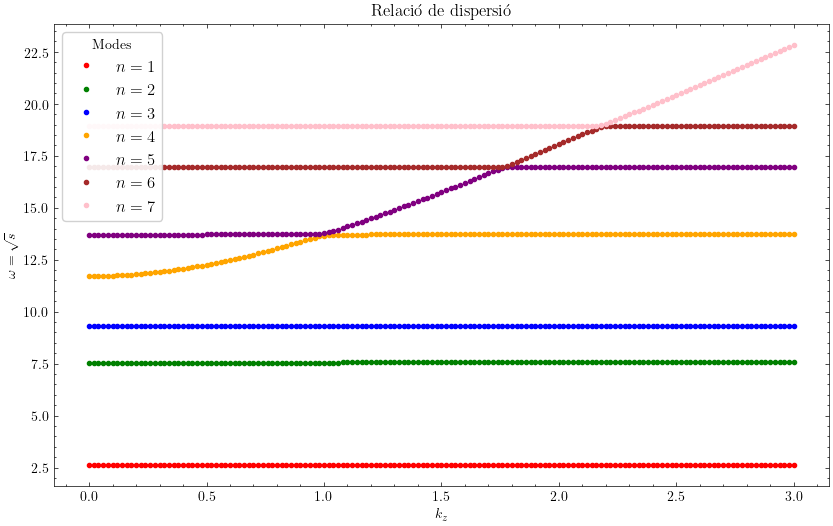

In [10]:
# Plot dispersion relation of the first 7 eigenvalues
plt.figure(figsize=(10, 6))
for i in range(7):
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
    plt.plot(kz_list, np.sqrt(evals_k[:, i].real), '.', label=f"$n={i+1}$", color=colors[i % len(colors)])
plt.xlabel(r"$k_z$")
plt.ylabel(r"$\omega = \sqrt{s}$")
plt.title("Relació de dispersió")
plt.grid(False)    
plt.legend(title='Modes', loc="upper left", frameon=True, fontsize=12, framealpha=0.9)
#plt.savefig("dd_modes_normals.png", dpi=300, bbox_inches='tight')
plt.show()

# Per veure amb més detall la relació de dispersió de cada mode la representam individualment.
#for i in range(7):
#    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
#    plt.plot(kz_list, np.sqrt(evals_k[:, i].real), '.', label=f"Mode {i+1}", color=colors[i % len(colors)])
#    plt.xlabel(r"$k_z$")
#    plt.ylabel(r"$\omega = \sqrt{s}$")
#    plt.title(f"Dispersion Relation for n = {i+1}")
#    plt.grid(True)
#    plt.show()
#plt.show()


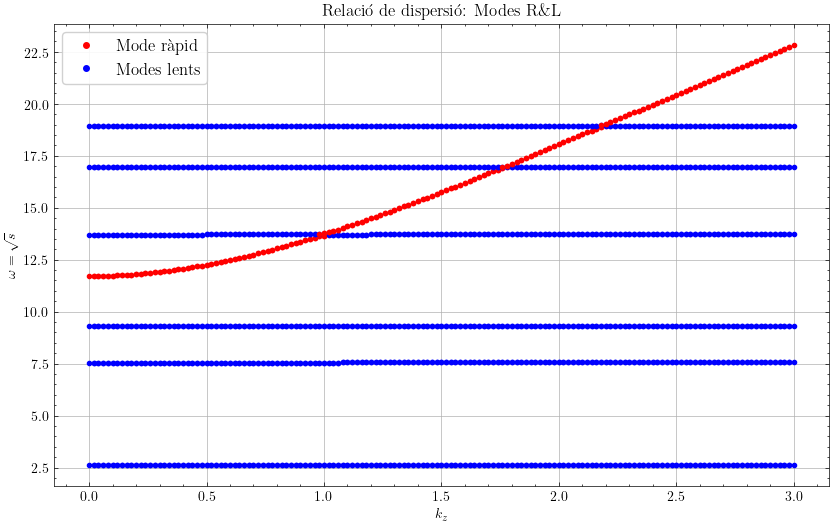

In [ ]:
# Inicialitzar un diccionari per emmagatzemar els valors de kz on es produeix l'increment dràstic
drastic_increase_points = {}

# Definir un llindar per detectar increments dràstics
threshold = 0.75  # Ajustar segons sigui necessari

# Iterar sobre cada mode
for i in range(7):
    omega = np.sqrt(evals_k[:, i].real)
    kz_values = kz_list

    # Calcular la derivada discreta de omega respecte a kz
    d_omega_d_kz = np.diff(omega) / np.diff(kz_values)

    # Trobar els índexs on la derivada supera el llindar
    indices = np.where(d_omega_d_kz > threshold)[0]

    # Crear un array per classificar cada interval segons el llindar
    is_drastic = d_omega_d_kz > threshold  # True si increment dràstic, False si suau

    # Emmagatzemar els valors de kz corresponents als increments dràstics

    drastic_increase_points[f"Mode {i+1}"] = kz_values[indices + 1]  # +1 perquè diff redueix la longitud en 1
    # Imprimir els resultats
    #print(f"Mode {i+1}: Increment dràstic a kz = {drastic_increase_points[f'Mode {i+1}']}")


colors_per_mode = {
    "Mode 1": ["blue"],
    "Mode 2": ["blue"],
    "Mode 3": ["blue"],
    "Mode 4": ["red", "red", "blue"],
    "Mode 5": ["blue", "red", "blue"],
    "Mode 6": ["blue", "red", "blue"],
    "Mode 7": ["blue", "red"],}
# No està gaire ben fet pq només ens serveix per 7 modes... però bé

plt.figure(figsize=(10, 6))
for i in range(7):
    omega = np.sqrt(evals_k[:, i].real)
    kz_values = kz_list

    # Derivada discreta
    d_omega_d_kz = np.diff(omega) / np.diff(kz_values)

    # Classificació suau / dràstic
    is_drastic = d_omega_d_kz > threshold

    mode_label = f"Mode {i+1}"
    assigned_colors = colors_per_mode.get(mode_label, ["blue"])  # Default color black if missing

    # Controlar l'índex dels colors
    color_idx = 0

    # Imprimir els resultats --- MOLT ÚTIL
    #print(f"Mode {i+1}: Increment dràstic a kz = {drastic_increase_points[f'Mode {i+1}']}")

    for j in range(len(d_omega_d_kz)):
        if color_idx >= len(assigned_colors):
            color = "blue"  # Per seguretat, si falten colors
        else:
            color = assigned_colors[color_idx]

        plt.plot(kz_values[j:j+2], omega[j:j+2], '.', color=color, linewidth=2)

        # Només canviem de color si hi ha un canvi de zona
        if j < len(d_omega_d_kz) - 1:
            if is_drastic[j] != is_drastic[j+1]:
                color_idx += 1

# kz_list ens dona una llista amb els valors de kz equidistants entre 0 i 3
# kz_inc ens dona una llista amb els valors de kz on es produeix l'increment dràstic

# El que vull fer és definir un valor de llindar per detectar increments dràstics en la relació de dispersió
# i després definir una funció a trossos per separar les zones amb increments dràstics i sense increments dràstics
# i representar-ho en el gràfic de la relació de dispersió.

plt.xlabel(r"$k_z$")
plt.ylabel(r"$\omega = \sqrt{s}$")
plt.title(r"Relació de dispersió: Modes R\&L")
custom_legend = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=4, label='Mode ràpid'),
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=4, label='Modes lents')]
plt.legend(handles=custom_legend, loc="upper left", frameon=True, fontsize=12, framealpha=0.9)
plt.grid(True)
#plt.savefig("dd_modes_rapid_i_lent.png", dpi=300, bbox_inches='tight')
plt.show()